In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

Visualizing Brain MRI Images

In [ ]:
tumor = []
healthy = []
for f in glob.iglob("/content/drive/MyDrive/Mri_Data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("/content/drive/MyDrive/Mri_Data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [ ]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

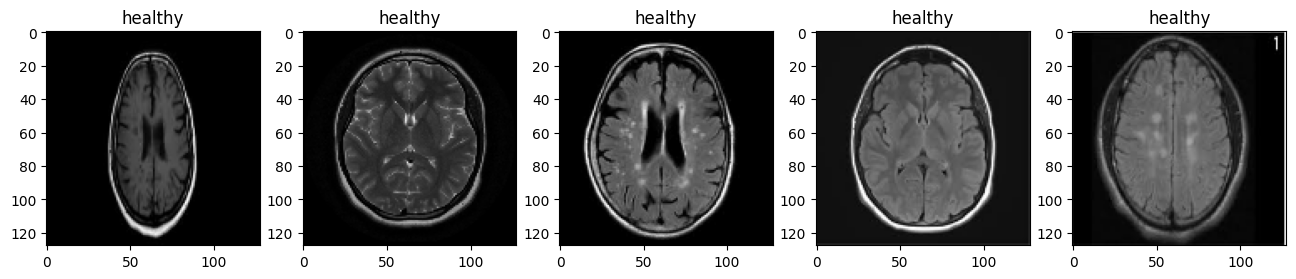

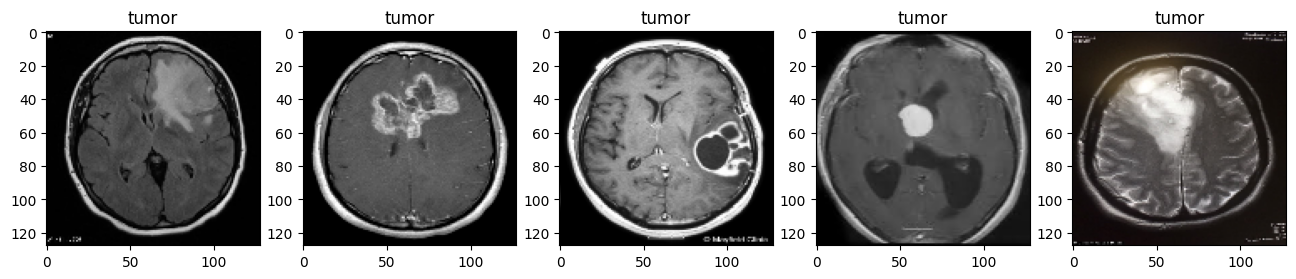

In [ ]:
plot_random(healthy, tumor, num=5)

Creating Model

In [ ]:
class MRI(Dataset):

    def __init__(self):

        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        self.mode = 'train'

        tumor = []
        healthy = []
        for f in glob.iglob("/content/drive/MyDrive/Mri_Data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("/content/drive/MyDrive/Mri_Data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}

        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}

        return sample

    def normalize(self):
        self.images = self.images/255.0



In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [ ]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x


In [ ]:
device = torch.device("cpu:0")
model = CNN().to(device)

In [ ]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [ ]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [ ]:
for epoch in range(1,1000):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # validate for the current epoch
    val_losses = []
    model.eval()

    mri_dataset.mode = 'val'

    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.000218	Val Loss: 3.355357
Train Epoch: 20	Train Loss: 0.000233	Val Loss: 3.360366
Train Epoch: 30	Train Loss: 0.000205	Val Loss: 3.363012
Train Epoch: 40	Train Loss: 0.000245	Val Loss: 3.363582
Train Epoch: 50	Train Loss: 0.000228	Val Loss: 3.365325
Train Epoch: 60	Train Loss: 0.000209	Val Loss: 3.366495
Train Epoch: 70	Train Loss: 0.000234	Val Loss: 3.371788
Train Epoch: 80	Train Loss: 0.000204	Val Loss: 3.413639
Train Epoch: 90	Train Loss: 0.000182	Val Loss: 3.415193
Train Epoch: 100	Train Loss: 0.000199	Val Loss: 3.419471
Train Epoch: 110	Train Loss: 0.000156	Val Loss: 3.422481
Train Epoch: 120	Train Loss: 0.000152	Val Loss: 3.423308
Train Epoch: 130	Train Loss: 0.000148	Val Loss: 3.427757
Train Epoch: 140	Train Loss: 0.000147	Val Loss: 3.431151
Train Epoch: 150	Train Loss: 0.000180	Val Loss: 3.434220
Train Epoch: 160	Train Loss: 0.000145	Val Loss: 3.438475
Train Epoch: 170	Train Loss: 0.000126	Val Loss: 3.487641
Train Epoch: 180	Train Loss: 0.000127	Va

In [ ]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [ ]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )


In [ ]:
accuracy_score(y_true, threshold(outputs))

0.7714285714285715

In [ ]:
index = 30
img = mri_dataset[index]['image']
l = mri_dataset[index]['label']

1.0

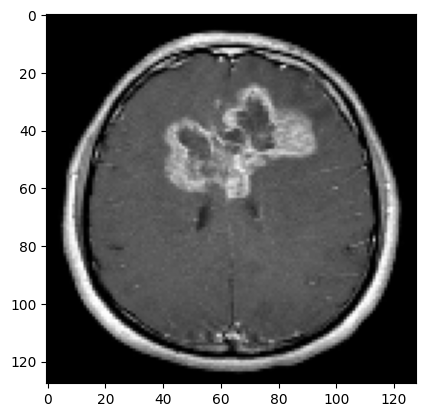

In [ ]:
img = torch.from_numpy(img).to(device)
l = mri_dataset[index]['label']
plt.imshow(img.reshape(128,128,3))
l

Text(0, 0.5, 'Loss')

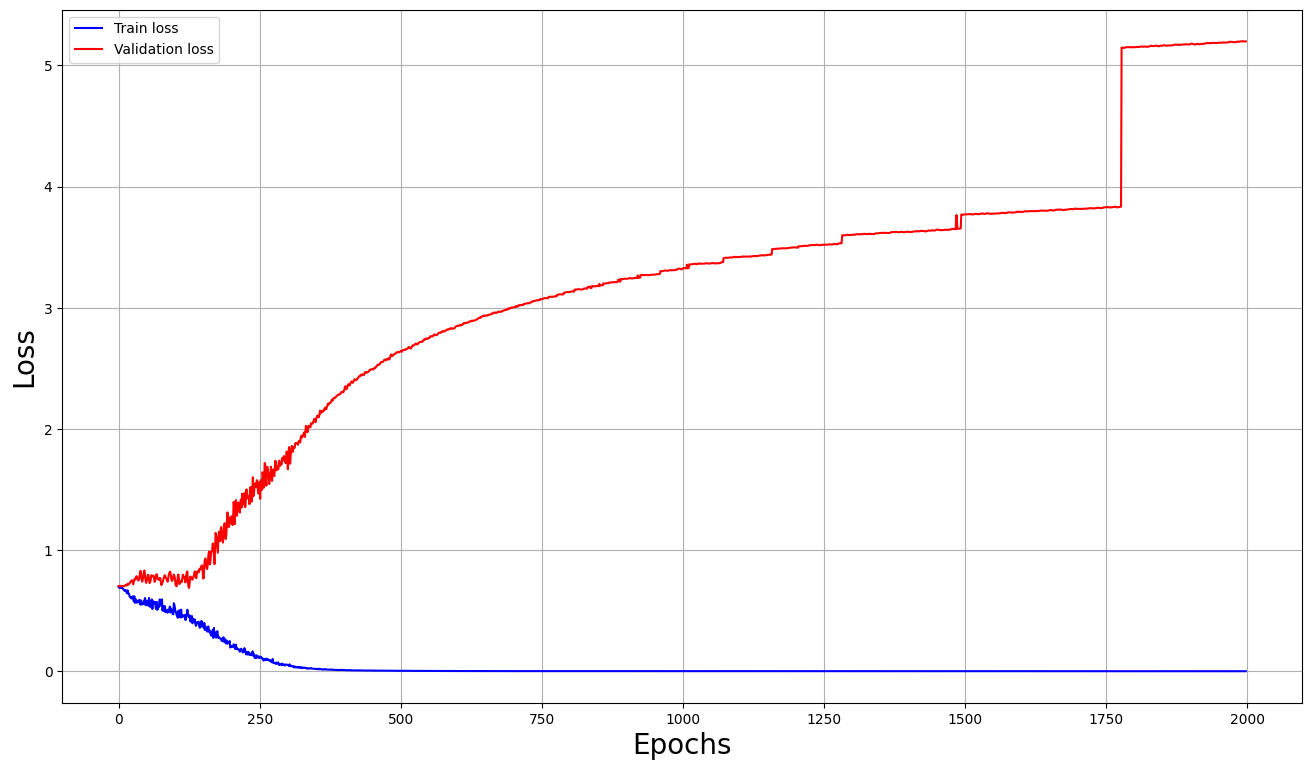

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

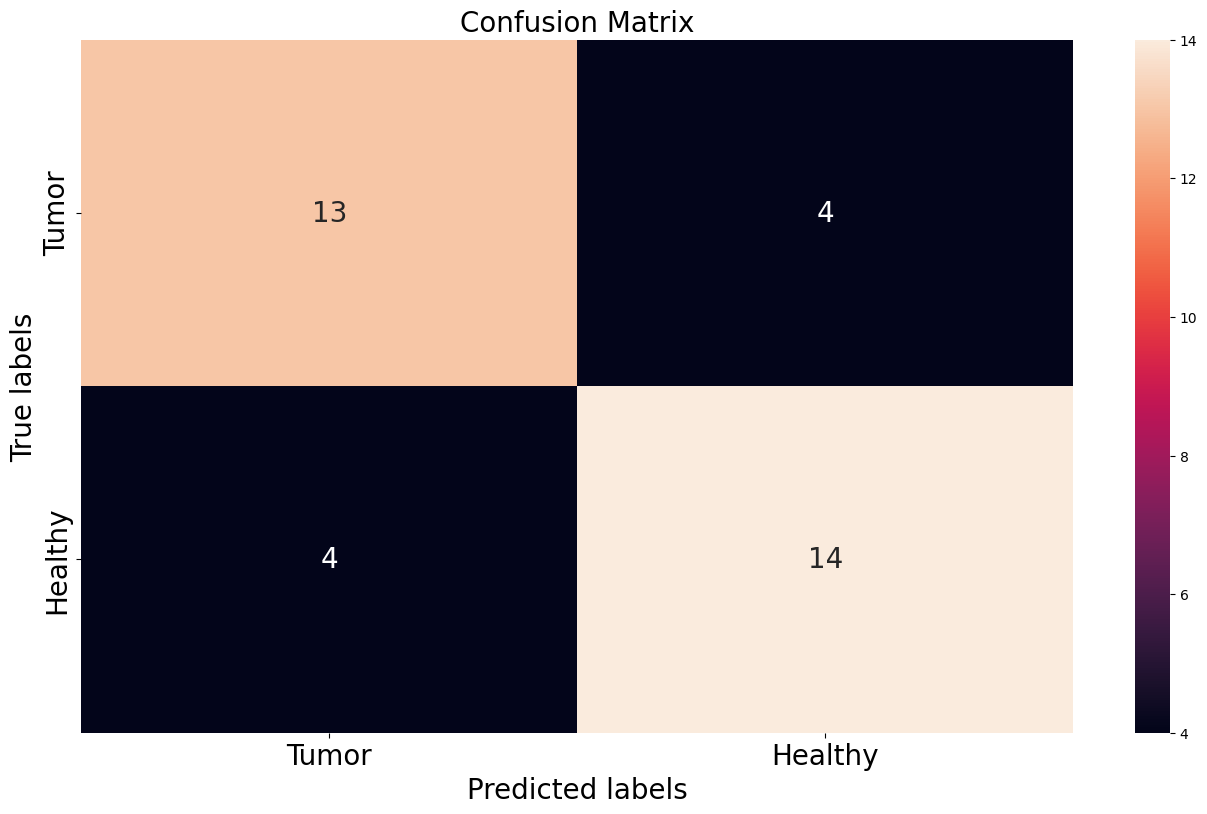

In [ ]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)